In [244]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import  StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [160]:
spark = SparkSession\
    .builder\
    .appName("classification-example")\
    .getOrCreate()

In [199]:
df = spark.read.csv(r"..\datasets\bank\bank.csv", inferSchema=True, header=True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



## Girdi Değişkenleri:
    age, job, marital, education, default, balance,
    housing, loan,contact, day, month, duration,
    campaign, pdays, previous, poutcome.
## Hedef Değişken
    deposit

In [200]:
pd.DataFrame(df.take(5), columns=df.columns).T

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [201]:
df.groupBy("deposit").count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [202]:
numeric_features = [feature for feature, dtype in df.dtypes if dtype == 'int' ]
numeric_features

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [203]:
# Sayısal değişkenler için özet istatistikler
df.select(*[numeric_features]).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [204]:
numeric_data = df.select(*numeric_features).toPandas()

In [263]:
abs(numeric_data.corr())

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.112300,0.000762,0.000189,0.005278,0.002774,0.020169
balance,0.112300,1.000000,0.010467,0.022436,0.013894,0.017411,0.030805
day,0.000762,0.010467,1.000000,0.018511,0.137007,0.077232,0.058981
duration,0.000189,0.022436,0.018511,1.000000,0.041557,0.027392,0.026716
campaign,0.005278,0.013894,0.137007,0.041557,1.000000,0.102726,0.049699
pdays,0.002774,0.017411,0.077232,0.027392,0.102726,1.000000,0.507272
previous,0.020169,0.030805,0.058981,0.026716,0.049699,0.507272,1.000000


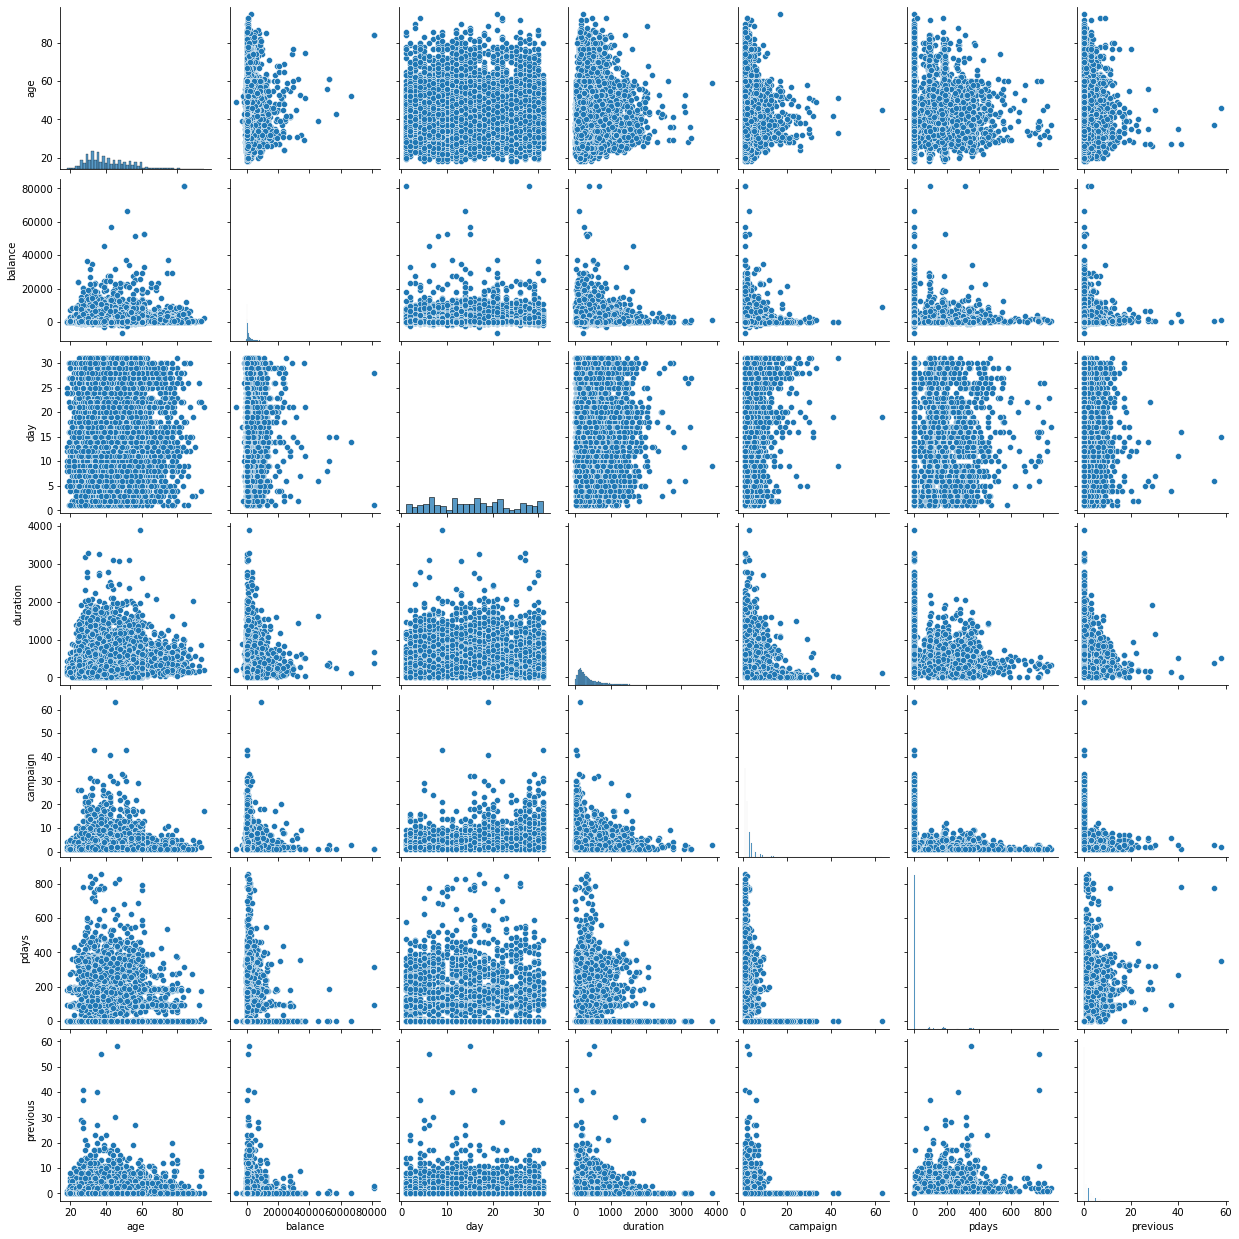

In [262]:
# Bağımsız değişkenler arasındaki korelasyonları gösteren scatter plot matrisi
sns.pairplot(numeric_data)
plt.show()

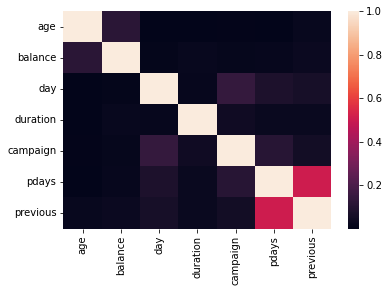

In [207]:
# Bağımsız değişkenler arasındaki korelasyonları gösteren ısı haritası
sns.heatmap(abs(numeric_data.corr()));

In [266]:
# Yüksek derecede ilişkili sayısal değişkenler yok.
# Bu nedenle, hepsini modelde kullancağız.
# Ancak gün ve ay sütunları pek kullanışlı değil, bu iki sütunu da kaldıracağız.
df = df.select('age', 'job', 'marital', 'education',
               'default', 'balance', 'housing', 'loan',
               'contact', 'duration', 'campaign', 'pdays',
               'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



## Veri Ön İşleme

In [216]:
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

## Pipeline

In [218]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [230]:
df.select("label","features").show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(30,[3,11,13,16,1...|
|  1.0|(30,[3,11,13,16,1...|
|  1.0|(30,[2,11,13,16,1...|
|  1.0|(30,[4,11,13,16,1...|
|  1.0|(30,[3,11,14,16,1...|
|  1.0|(30,[0,12,14,16,2...|
|  1.0|(30,[0,11,14,16,2...|
|  1.0|(30,[5,13,16,18,2...|
|  1.0|(30,[2,11,13,16,1...|
|  1.0|(30,[4,12,13,16,1...|
|  1.0|(30,[3,12,13,16,1...|
|  1.0|(30,[1,11,13,16,1...|
|  1.0|(30,[0,11,14,16,2...|
|  1.0|(30,[1,12,14,16,1...|
|  1.0|(30,[2,12,14,16,1...|
|  1.0|(30,[0,14,16,18,2...|
|  1.0|(30,[1,12,15,16,1...|
|  1.0|(30,[4,11,13,16,1...|
|  1.0|(30,[3,11,13,16,1...|
|  1.0|(30,[3,13,16,20,2...|
+-----+--------------------+
only showing top 20 rows



In [232]:
train, test = df.randomSplit([0.7,0.3], seed=2018)
print(train.count())
print(test.count())

7855
3307


## Gradient-Boosted Tree Classifier

In [237]:
gbt = GBTClassifier(maxIter=10)
gbt_model = gbt.fit(train)
predictions = gbt_model.transform(test)

In [238]:
predictions.select("label", "prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



## Model başarısı değerlendirme

In [273]:
evaluator = BinaryClassificationEvaluator()
score = evaluator.evaluate(predictions,{
    evaluator.metricName: "areaUnderROC"
})
print("model başarısı: ", score)

model başarısı:  0.8935091626908479


In [260]:
paramGrid = (ParamGridBuilder()
    .addGrid(gbt.maxDepth, [2, 4, 6])
    .addGrid(gbt.maxBins, [20, 60])
    .addGrid(gbt.maxIter, [10, 20])
    .build()
)
cv = CrossValidator(estimator=gbt,estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [261]:
cv_model = cv.fit(train)
final_predictions = cv_model.transform(test)
final_score = evaluator.evaluate(
    final_predictions, params={
        evaluator.metricName:"areaUnderROC"
    }
)
print('Model Tuning sonrası final modeli başarısı: ', final_score)

0.8929212099379359